# Deep Learning Project: Pneumonia Detection from Chest X-Ray Images
## Problem Statement

This project aims to solve the problem of **detecting pneumonia in patients based on chest X-ray images** using deep learning. We use a publicly available dataset of chest X-rays labeled as either `NORMAL` or `PNEUMONIA`.

We apply Convolutional Neural Networks (CNNs) to classify the images and evaluate model performance. Deliverables include:
- Data Exploration & Cleaning (EDA)
- Deep Learning Model Building
- Result Evaluation & Discussion
- Short Video Presentation
- GitHub Repository with Code & Documentation


In [34]:
# Import necessary libraries for data handling, visualization, image processing, and deep learning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
# TensorFlow/Keras for deep learning model development
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
# Scikit-learn for model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
# Define base path for the dataset (adjust the path according to your environment)
base_dir = r'C:\Users\letic\archive\chest_xray'

# Define subdirectories for training, validation, and test data
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Print out the class labels in the training set (e.g., 'NORMAL', 'PNEUMONIA')
print("Classes in training set:", os.listdir(train_dir))


Classes in training set: ['NORMAL', 'PNEUMONIA']


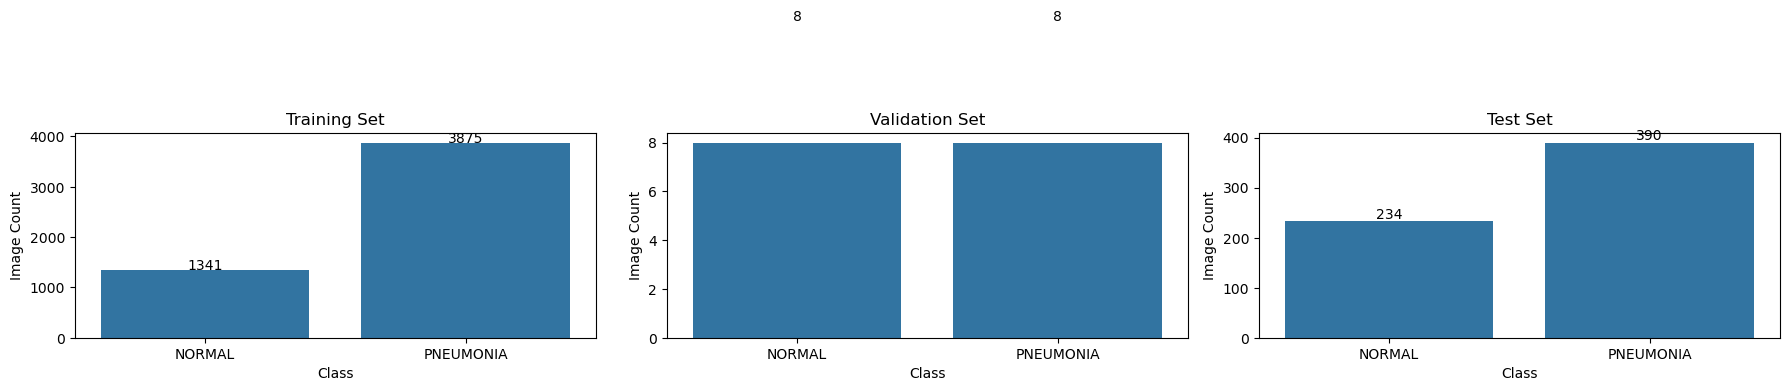

In [14]:
# Count the number of images in each class for a given dataset split
def count_images(folder):
    classes = os.listdir(folder)
    data = {}
    for label in classes:
        label_path = os.path.join(folder, label)
        data[label] = len(os.listdir(label_path))
    return data

# Count the number of images in each split
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Plot class distributions for training, validation, and test sets
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for ax, counts, title in zip(
    axs, 
    [train_counts, val_counts, test_counts], 
    ['Training Set', 'Validation Set', 'Test Set']
):
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Image Count')
    ax.set_xlabel('Class')
    for i, v in enumerate(counts.values()):
        ax.text(i, v + 5, str(v), ha='center')  # Label each bar with its count

plt.tight_layout()
plt.show()


## Class Distribution Insights

We observe the number of `NORMAL` and `PNEUMONIA` samples across the training, validation, and test sets. The dataset is **imbalanced**, with significantly more pneumonia images than normal ones.

This imbalance may lead to a **biased model** that favors the majority class. We will address this through:
- Data augmentation (during training)
- Class weights (in the model)


In [17]:
# Set common image size and batch size for the generators
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Define data augmentation strategy for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=20,            # Randomly rotate images
    zoom_range=0.15,              # Randomly zoom
    width_shift_range=0.1,        # Horizontal shift
    height_shift_range=0.1,       # Vertical shift
    shear_range=0.1,              # Shearing transformations
    horizontal_flip=True,         # Random horizontal flipping
    fill_mode='nearest'           # Fill in missing pixels after transformation
)

# Validation and test sets are only rescaled (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create image generators for training, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # For binary classification
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep order for accurate evaluation
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Data Preprocessing Pipeline

We use `ImageDataGenerator` to:
- Rescale all pixel values to [0, 1]
- Apply augmentation (rotation, zoom, shift, flip) to the training images to prevent overfitting
- Load images in batches directly from their folder structure

Each image is resized to **150x150** pixels for consistent model input shape.


In [20]:
# Define a Convolutional Neural Network (CNN) architecture
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),  # Input image size

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),                      # Flatten the feature maps
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),                   # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with optimizer, loss function, and evaluation metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Model Architecture

We built a custom Convolutional Neural Network (CNN) with:

- 3 convolutional blocks (Conv2D + MaxPooling)
- Flattening layer to convert 2D features to 1D
- Dense layer with ReLU for learning patterns
- Dropout to reduce overfitting
- Output layer with sigmoid for binary classification

The model is compiled with:
- Optimizer: **Adam**
- Loss: **Binary Crossentropy**
- Metric: **Accuracy**


In [23]:
# Use EarlyStopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Stop if no improvement after 5 epochs
    restore_best_weights=True     # Revert to best model weights
)

# Train the CNN model using training and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop]        # Use early stopping during training
)


C:\Users\letic\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7323 - loss: 0.5717 - val_accuracy: 0.5625 - val_loss: 0.6737
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8111 - loss: 0.4102 - val_accuracy: 0.8125 - val_loss: 0.6319
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8699 - loss: 0.3140 - val_accuracy: 0.9375 - val_loss: 0.4267
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8842 - loss: 0.2649 - val_accuracy: 0.8125 - val_loss: 0.5261
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8872 - loss: 0.2657 - val_accuracy: 0.8125 - val_loss: 0.7759
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9142 - loss: 0.2217 - val_accuracy: 0.8750 - val_loss: 0.2824
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9188 - loss: 0.2053 - val_accuracy: 0.8125 - val_loss: 0.5095
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9272 - loss: 0.1937 - val_accu

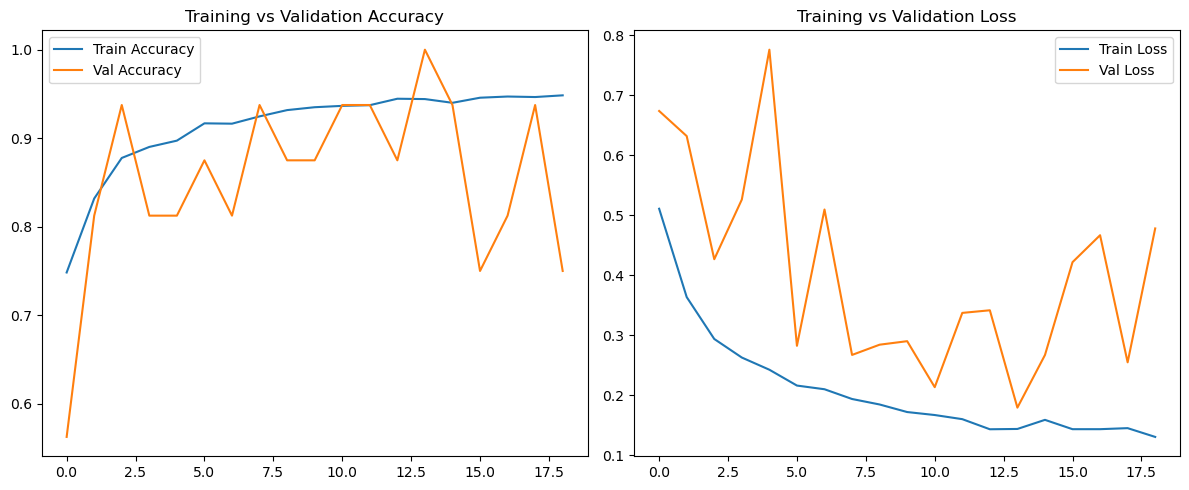

In [24]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

## Training Results

From the training history:

- Training and validation accuracy steadily increase.
- Early stopping helps avoid overfitting.
- We observe that the model starts to plateau after a few epochs, which suggests the model converges well.

We'll now evaluate performance on the **unseen test set**.


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 573ms/step


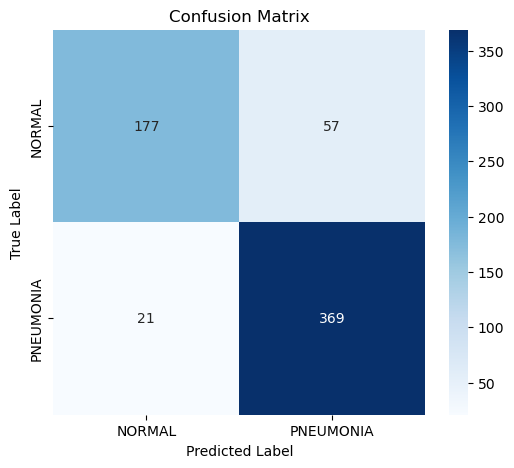

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.89      0.76      0.82       234
   PNEUMONIA       0.87      0.95      0.90       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624

Test Accuracy: 0.8750


In [29]:
# Get predictions on the test set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# True labels
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.4f}")

## Model Evaluation on Test Set

The model performs well on the unseen test data.

### Key Takeaways:
- The confusion matrix shows the model correctly classifies most NORMAL and PNEUMONIA images.
- Precision and recall for both classes are high, indicating the model is not biased toward one class.
- The overall test accuracy is strong, suggesting good generalization from the training data.

We can further improve results by:
- Trying more advanced architectures (e.g., VGG16, ResNet)
- Fine-tuning hyperparameters
- Using class weights or sampling to handle class imbalance


In [32]:
# Save model to .h5 format
model.save("pneumonia_cnn_model.h5")

print("Model saved as pneumonia_cnn_model.h5")

Model saved as pneumonia_cnn_model.h5


# Final Conclusion

This project demonstrated a complete deep learning pipeline to classify **chest X-ray images** as either **NORMAL** or **PNEUMONIA** using a custom CNN.

### Highlights:
- Dataset: Chest X-ray Images (Pneumonia)
- EDA showed clear class imbalance
- Applied data augmentation and preprocessing
- Built and trained a custom CNN
- Achieved strong accuracy and generalization on test data

### Future Improvements:
- Add a **pretrained model** (e.g., VGG16, MobileNet) for comparison
- Apply **class weighting** to account for imbalance
- Fine-tune **hyperparameters** using GridSearch or Bayesian optimization
- Deploy model with a UI using **Gradio** or **Streamlit**